### Matt Kendall (August 21, 2020)

### Analyzing Applications for Permanent Employment Certification

### MSCA 37014 | Python for Analytics | Professor S. Chaudhary | Team Project

### Oleksiy if you're thinking about what to include in a final script, I'd recommend my short data prep section (so that the rest of script runs successfully, the second sns pair plot, the acceptance rate section (purple bar charts), and maybe the wait times section (light blue bar charts), followed by the conclusion. If you have any questions, hit me up in the slack. 

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../Data/Clean/project_data_cleaned.csv', encoding='latin1')
df = df.drop("Unnamed: 0", axis = 1)

df.head().T

C:\Users\mattk\anaconda3\envs\msca\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
case_status,Denied,Certified-Expired,Denied,Certified,Denied
received_date,9/3/2009,3/29/2010,8/10/2010,2/3/2011,3/10/2011
decision_date,4/30/2020,10/18/2019,4/30/2020,5/28/2020,6/17/2020
employer_city,CHICAGO,GERMANTOWN,N. VALLEY STREAM,CAMPBELL,YONKERS
employer_state_province,ILLINOIS,MARYLAND,NEW YORK,CALIFORNIA,NEW YORK
employer_num_employees,2,0,3,29,43
emp_contact_city,chicago,GERMANTOWN,N. VALLEY STREAM,Sunnyvale,YONKERS
emp_contact_state_province,ILLINOIS,MARYLAND,NEW YORK,CALIFORNIA,NEW YORK
emp_contact_postal_code,60647,20874,11580,94086,10703
agent_attorney_name,Christopher E Kurczaba,WINSTON W TSAI,DANIEL J SULLIVAN,Sonal Kinger,VERNON L DUTTON


In [7]:
df.shape

(71942, 33)

In [8]:
df['received_date'] = pd.to_datetime(df['received_date'], format = '%m/%d/%Y')
df['decision_date'] = pd.to_datetime(df['decision_date'], format = '%m/%d/%Y')

#This variable creation is similar to analogous to a similar transformation in Albert's work 
df['wait_time'] = (df['decision_date'] - df['received_date'])/np.timedelta64(1, "M")

df['decision_month'] = df['decision_date'].dt.to_period('M')

# Determining how long the business have been established
df['age_of_business'] = 2020 - df.employer_year_commenced_business
df['age_of_business_cut'] = pd.qcut(df.age_of_business, 10)

#NAICS is a hierarchical industry code, so grabbing the first two digits gives us some information 
# about the type of businesses applying for the visas while maintaining a manageable number of 
# levels in the data
df['naics_group'] = df.naics_code.astype(str).str[:2]

#Creating a wage variable that's on a consistent, annual basis 
df['pw_wage'] = df.pw_wage.str.replace(',', '')
df['pw_wage'] = pd.to_numeric(df.pw_wage)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Hour", df.pw_wage*2080, df.pw_wage)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Week", df.pw_wage*52, df.pw_wage_adj)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Month", df.pw_wage*12, df.pw_wage_adj)
df['pw_wage_adj'] = np.where(df.pw_unit_of_pay == "Bi-Weekly", df.pw_wage*26, df.pw_wage_adj)

## Seaborn Pair Plot

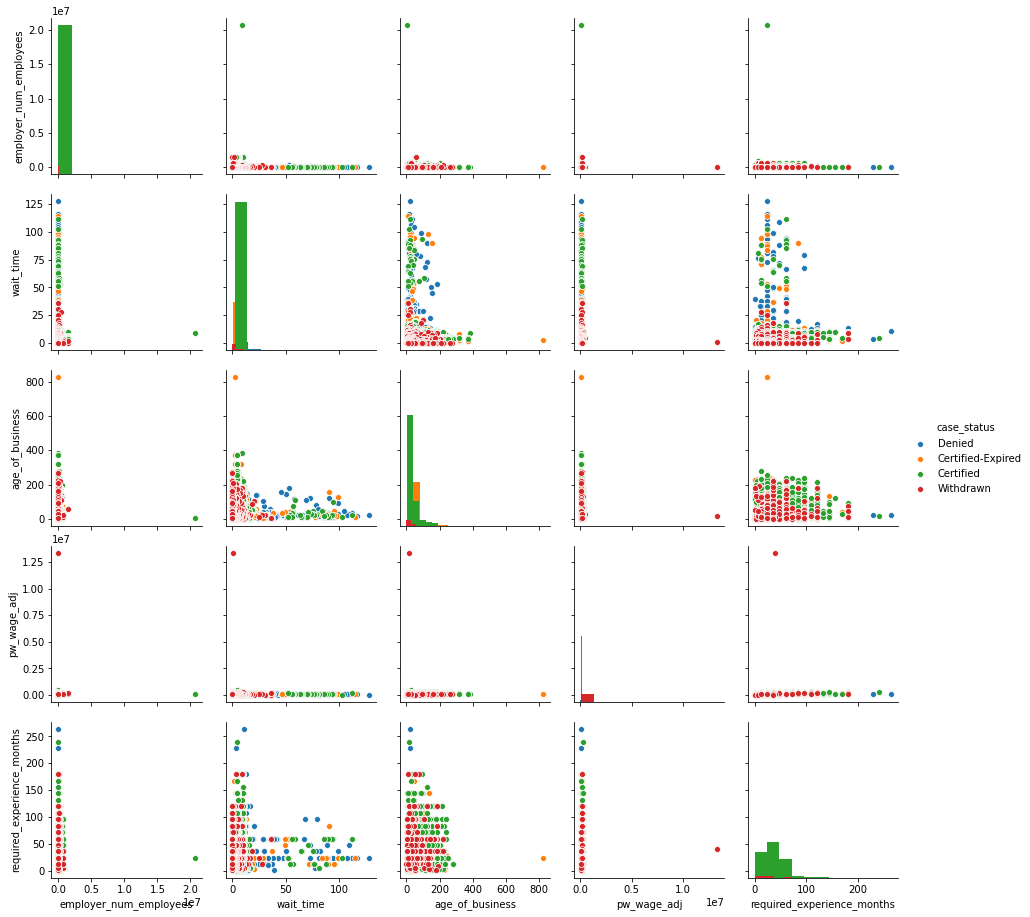

In [18]:
sns.pairplot(df[['case_status','employer_num_employees', 'wait_time', 'age_of_business', 'pw_wage_adj', 'required_experience_months']],
            diag_kind = 'hist',
            hue = 'case_status')

As discussed in class, perhaps not the most useful visual, but it looks cool. It's somewhat difficult to determine relationships between certain variables because signficant outliers skew the scale (e.g. $10m+ salary, 800 year old business...). The coloring is interesting though. It's clear that there's clear patterns between some of the variables and teh case outcome. Let's try again capping some of the high variables. 

In [42]:
df_sns = df[['case_status','employer_num_employees', 'wait_time', 'age_of_business', 'pw_wage_adj', 'required_experience_months']].copy()

#Capping all of the variables at the 99th percentile
for col in ['employer_num_employees', 'wait_time', 'age_of_business', 'pw_wage_adj', 'required_experience_months']:
    df_sns[col] = np.where(df_sns[col] > df_sns[col].quantile(.995), df_sns[col].quantile(.995), df_sns[col])

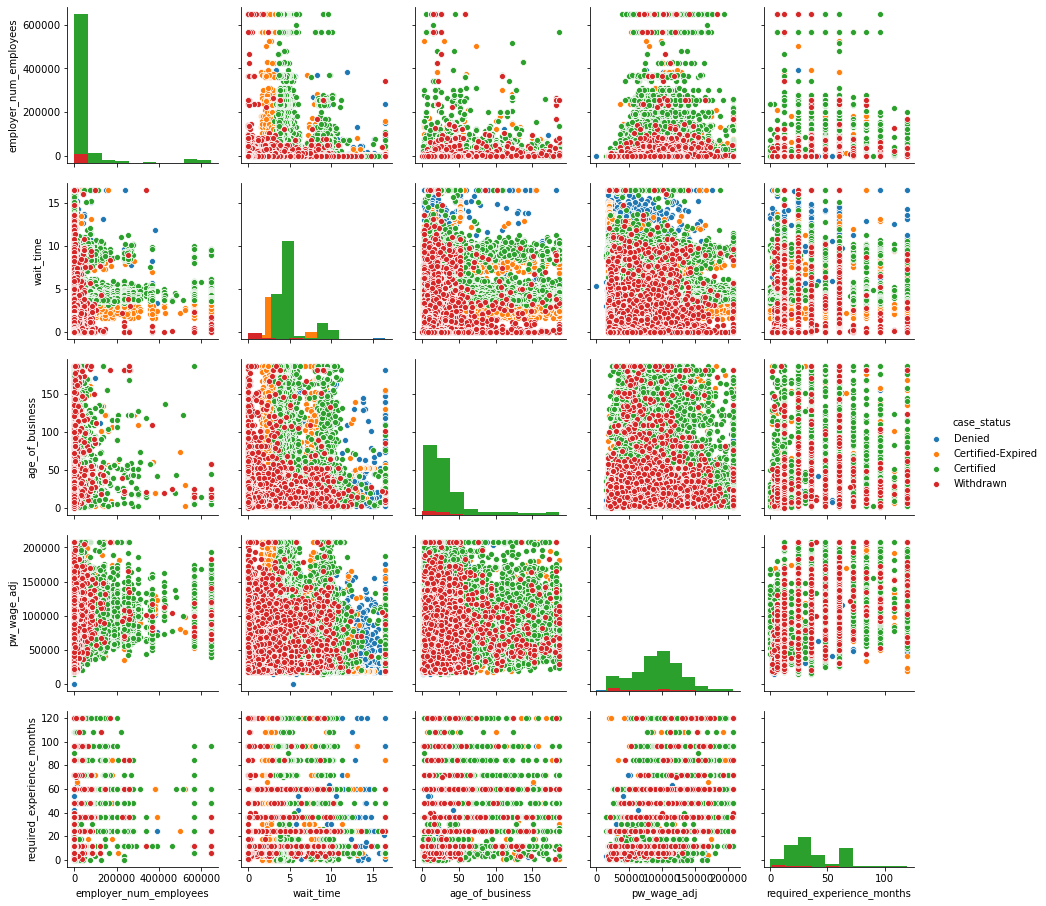

In [43]:
sns.pairplot(df_sns,
            diag_kind = 'hist',
            hue = 'case_status')

Better to look at, but unfortunately still not getting a ton out of it. There's some nuggets though. Looks like if you have a high wait time, it's more likely that you'll get denied. Looks like if you're coming over for a high wage job you won't get denied (but you still might have to withdraw your application. Higher wage positions for business that have been open for longer see more success. Employees tend to withdraw applications quickly, rather than wait through the long process of actually getting a decision. 

Trying one more time, grouping Denied and Withdrawn in one level for case status, Certitifed and Certified-Expired in another. 

In [44]:
df_sns['case_status'] = np.where((df_sns['case_status'] == 'Certified') | (df_sns['case_status'] == 'Certified-Expired'), 1, 0)

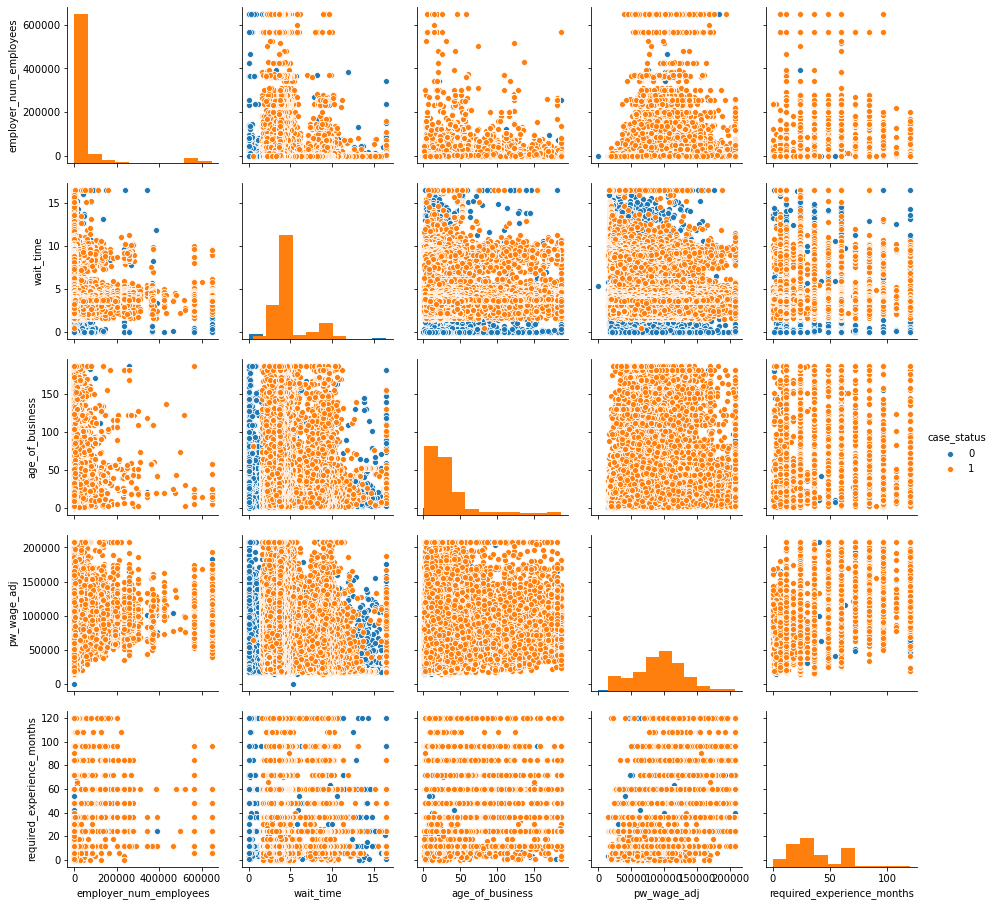

In [45]:
sns.pairplot(df_sns,
            diag_kind = 'hist',
            hue = 'case_status')

Unfortuntately worse... I think the orange dots are just covering up blue ones, but it certainly makes it hard to pick out any patterns. Maybe we'll just need to stick with the second one. 

## Acceptance Rates

Now let's look at acceptance rates by a few categorical variables (month of decision, NAICS group, visa type, country, age of business) that we didn't pull into the pair plot. First, checking if there's any relationship between decision timing and case outcome in this data

In [62]:
pd.crosstab(df.decision_month, df.case_status)

case_status,Certified,Certified-Expired,Denied,Withdrawn
decision_month,,,,
2019-10,0,7029,408,290
2019-11,0,4980,236,274
2019-12,0,4063,326,327
2020-01,4453,255,235,307
2020-02,3369,0,348,238
2020-03,7028,0,259,299
2020-04,13130,0,299,287
2020-05,11554,0,332,463
2020-06,10374,0,439,340


I'm not sure I get how the data is structured... All cases decided in 2019 have a separate certification designation than those in 2020. The volume of decisions is much lower from Nov 2019 through Feb 2020 than the other months. In the graphs below, I'm assuming 'Certified' and 'Certified-Expired' are equivalent outcomes from teh perspective of the applicant

Text(0.5, 1.0, 'Percent of Applications Accepted by Decision Month')

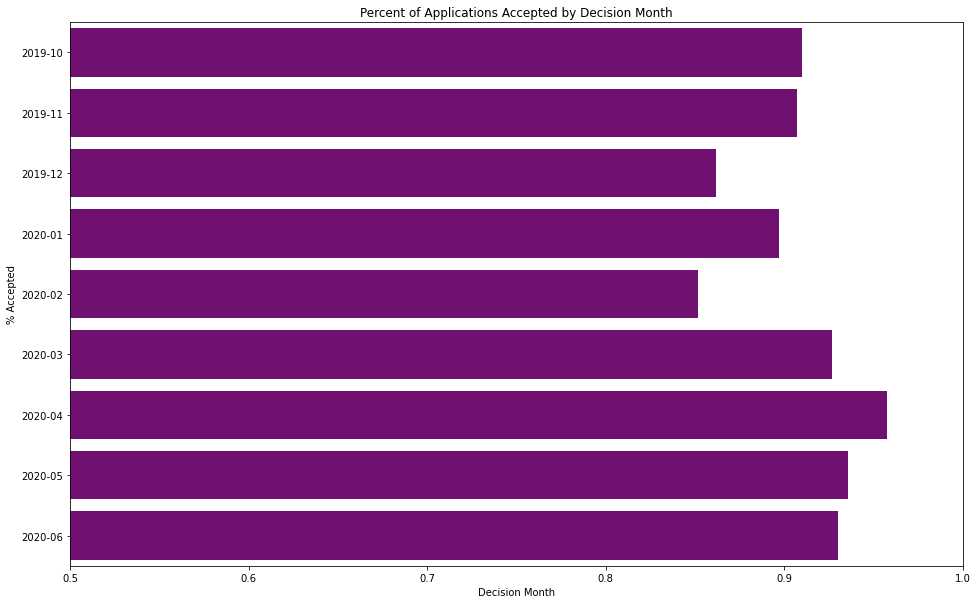

In [122]:
table = pd.crosstab(df.decision_month, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[['pct_accepted']]

plt.figure(figsize = (16, 10))

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple', orient='h')
ax.set(xlabel = 'Decision Month', ylabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by Decision Month')

Not many major trends in the data by month. I'm not sure if it's captured in the date ranges, but I was curious if any of the Trump administration orders were going to have noticeable effects. 

Text(0.5, 1.0, 'Percent of Applications Accepted by NAICS Group')

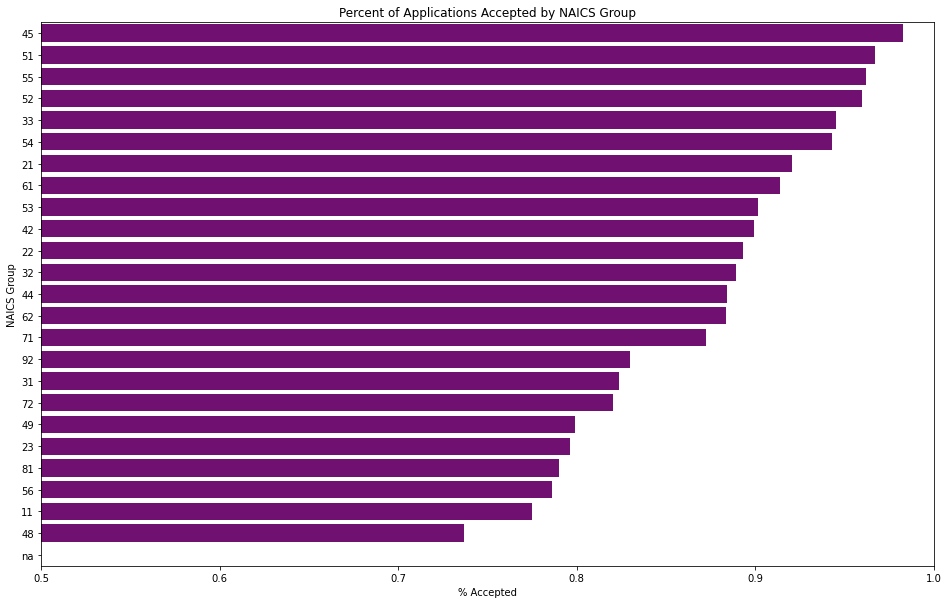

In [60]:
table = pd.crosstab(df.naics_group, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[['pct_accepted']].sort_values('pct_accepted', ascending=False)

plt.figure(figsize = (16, 10))

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'NAICS Group', xlabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by NAICS Group')

We'd need to break 33 and 45 out into different subgroups to get more info, but it seems like the remainder of the top 5 (51, 55, 52) likely correspond to high paying positions. At the bottom, we tend to see the opposite. Industries dominated by blue collar jobs. 

For reference, here are the different NAICS group classes. 

- 11	Agriculture, Forestry, Fishing and Hunting
- 21	Mining
- 22	Utilities
- 23	Construction
- 31	Manufacturing
- 32  Manufacturing
- 33  Manufacturing
- 42	Wholesale Trade
- 44  Retail Trade
- 45	Retail Trade
- 48  Transportation and Warehousing
- 49	Transportation and Warehousing
- 51	Information
- 52	Finance and Insurance
- 53	Real Estate Rental and Leasing
- 54	Professional, Scientific, and Technical Services
- 55	Management of Companies and Enterprises
- 56	Administrative and Support and Waste Management and Remediation Services
- 61	Educational Services
- 62	Health Care and Social Assistance
- 71	Arts, Entertainment, and Recreation
- 72	Accommodation and Food Services
- 81	Other Services (except Public Administration)
- 92	Public Administration

Text(0.5, 1.0, 'Percent of Applications Accepted by Visa Type')

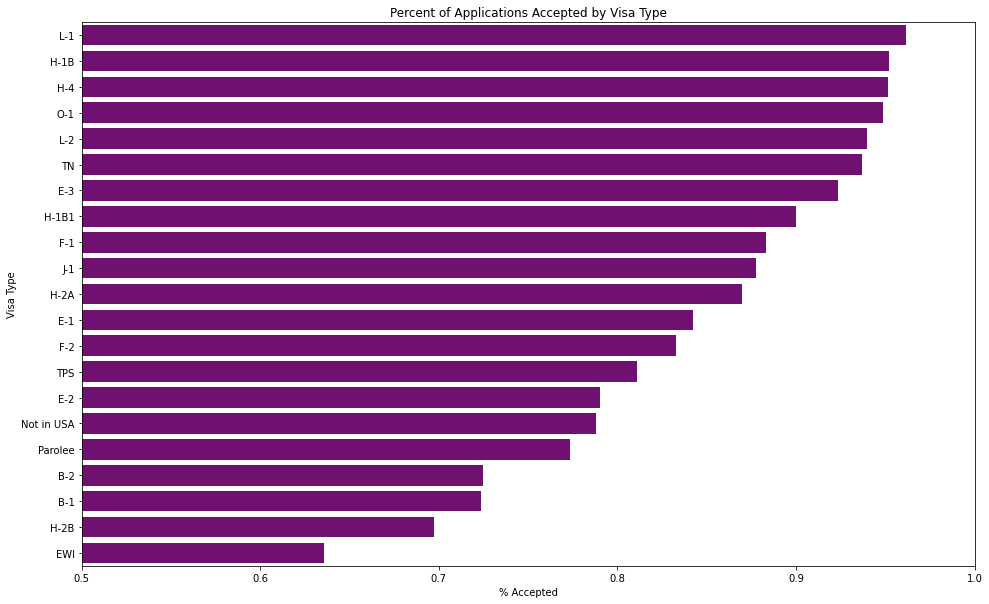

In [57]:
table = pd.crosstab(df.class_of_admission, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[table.sum(axis=1) > 50]
table = table[['pct_accepted']].sort_values('pct_accepted', ascending = False)

plt.figure(figsize = (16, 10))

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'Visa Type', xlabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by Visa Type')

Frankly, I'd have to do some research on the different visa types to try to draw more conclusions here. However, it's clear that certain pathways are more likely to see success than others. 

Text(0.5, 1.0, 'Percent of Applications Accepted by Visa Type')

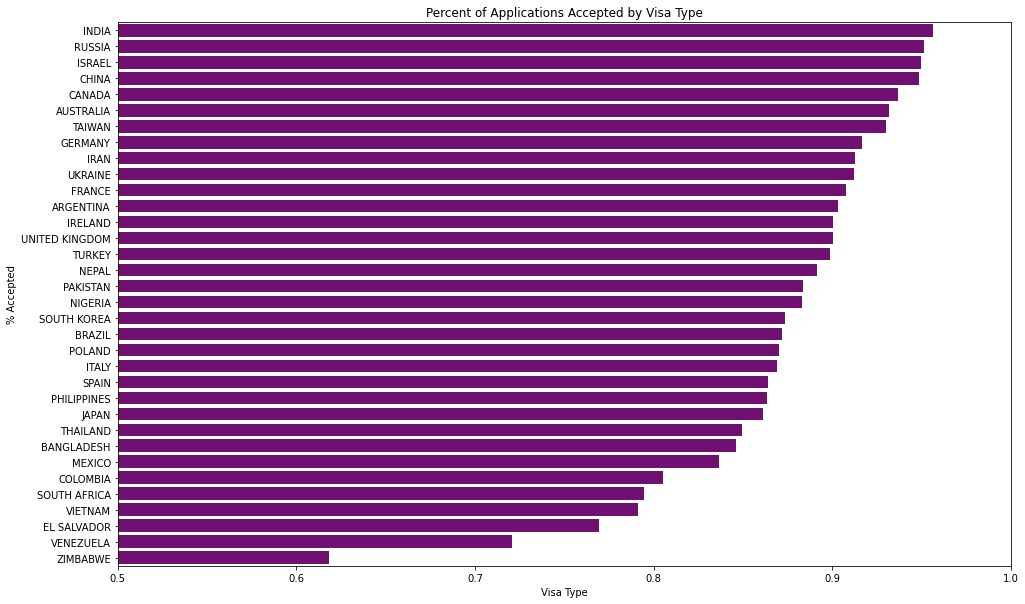

In [75]:
plt.figure(figsize = (16, 10))

table = pd.crosstab(df.country_of_citizenship, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[table.sum(axis=1) > 200]
table = table[['pct_accepted']].sort_values('pct_accepted', ascending=False)

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'Visa Type', xlabel = '% Accepted', xlim=(0.5, 1))
ax.set_title('Percent of Applications Accepted by Visa Type')

Clearly effects by country as well. While at a glance there's likely some vague developing/developed differential here, it doesn't hold up absolutely. For instance, Nepalese applicants fare better than Japanese applicants. 

Text(0.5, 1.0, 'Percent of Applications Accepted by Age of Business')

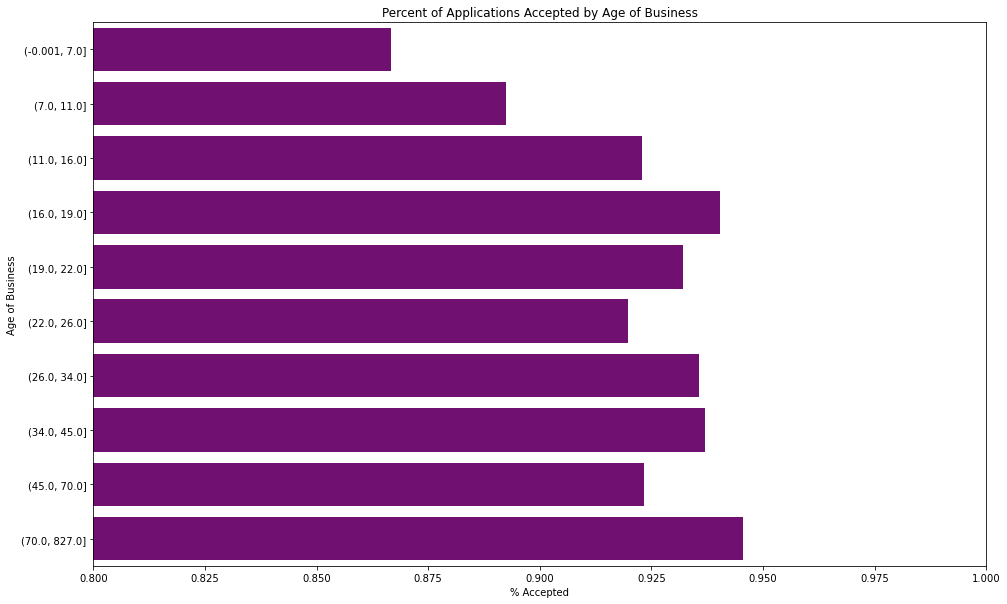

In [59]:
plt.figure(figsize = (16, 10))

table = pd.crosstab(df.age_of_business_cut, df.case_status)
table['cert'] = table['Certified'] + table['Certified-Expired']
table = table.drop(['Certified', 'Certified-Expired'], axis=1)

table['pct_accepted'] = table['cert']/table.sum(axis=1)
table = table[['pct_accepted']]

ax = sns.barplot(y = table.index, x = table.pct_accepted, color = 'purple')
ax.set(ylabel = 'Age of Business', xlabel = '% Accepted', xlim=(0.8, 1))
ax.set_title('Percent of Applications Accepted by Age of Business')

Mild effects by age of business. There's generally an increasing trend, but probably a stronger takeway is that the newest operations do much person. There's little difference if you've been around for 16+ years, but below that you're facing an uphill battle. 

## Salary

Now we'll look at salary by the same cuts of the data that we just explored acceptance rates. 

Text(0.5, 1.0, 'Mean Salary by Decision Month')

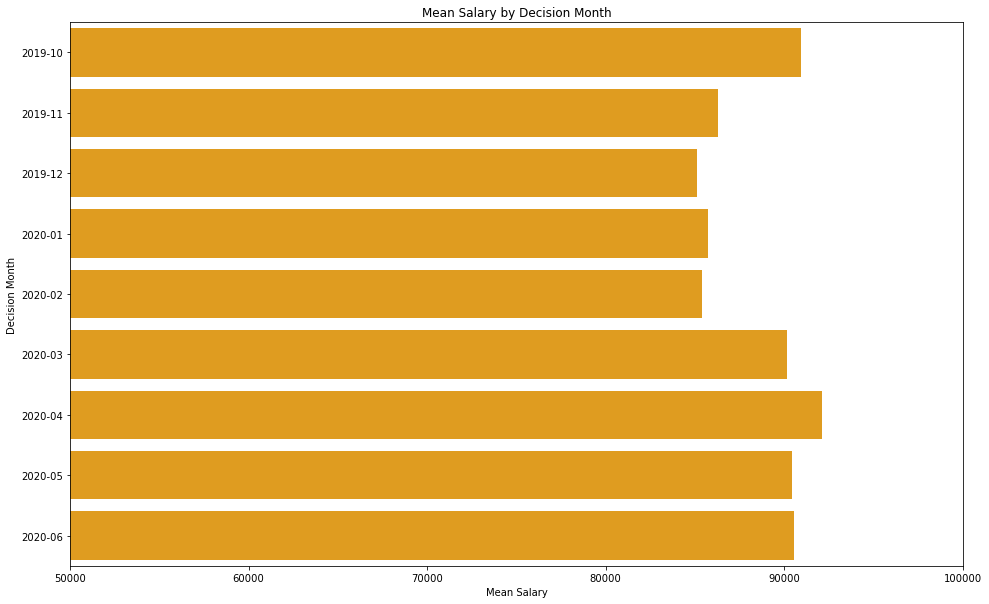

In [63]:
plt.figure(figsize = (16, 10))

table = df.groupby("decision_month", as_index=False)["pw_wage_adj"].mean()

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Decision Month', xlabel = 'Mean Salary', xlim=(50000, 100000))
ax.set_title('Mean Salary by Decision Month')

Again no time related effect on position salaries in this data. 

Text(0.5, 1.0, 'Mean Salary by NAICS Group')

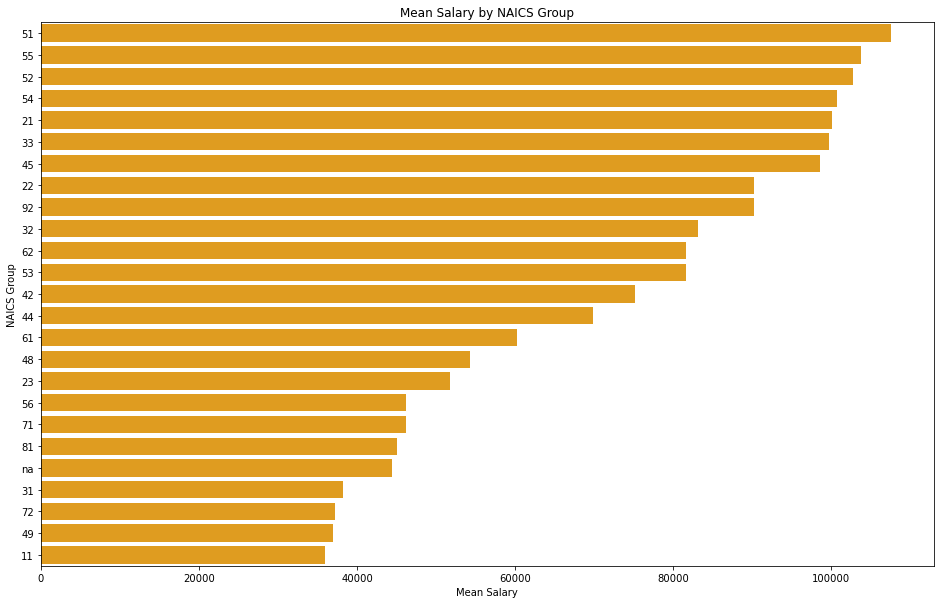

In [64]:
plt.figure(figsize = (16, 10))

table = df.groupby("naics_group", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(25)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'NAICS Group', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by NAICS Group')

Huge difference by NAICS group. As expected the same groups appear at the top (51, 52, 55) and bottom (11) as in the same chart for acceptance rate, validating our assumption that salary of position is the main driver in the variation of results by NAICS group. A possible extension is to look at that effect more rigorously. 

Text(0.5, 1.0, 'Mean Salary by Visa Type')

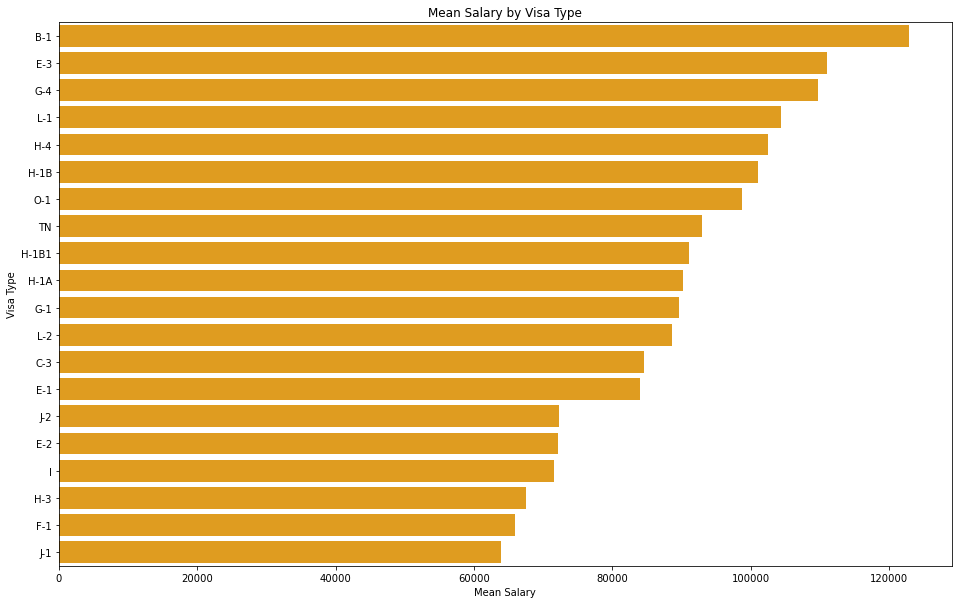

In [65]:
plt.figure(figsize = (16, 10))

table = df.groupby("class_of_admission", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(20)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Visa Type', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Visa Type')

Major differences in salary by visa type as well. Notable that the most common and most accepted visas don't necessarily correspond to the highest salaries. 

Text(0.5, 1.0, 'Mean Salary by Country of Citizenship')

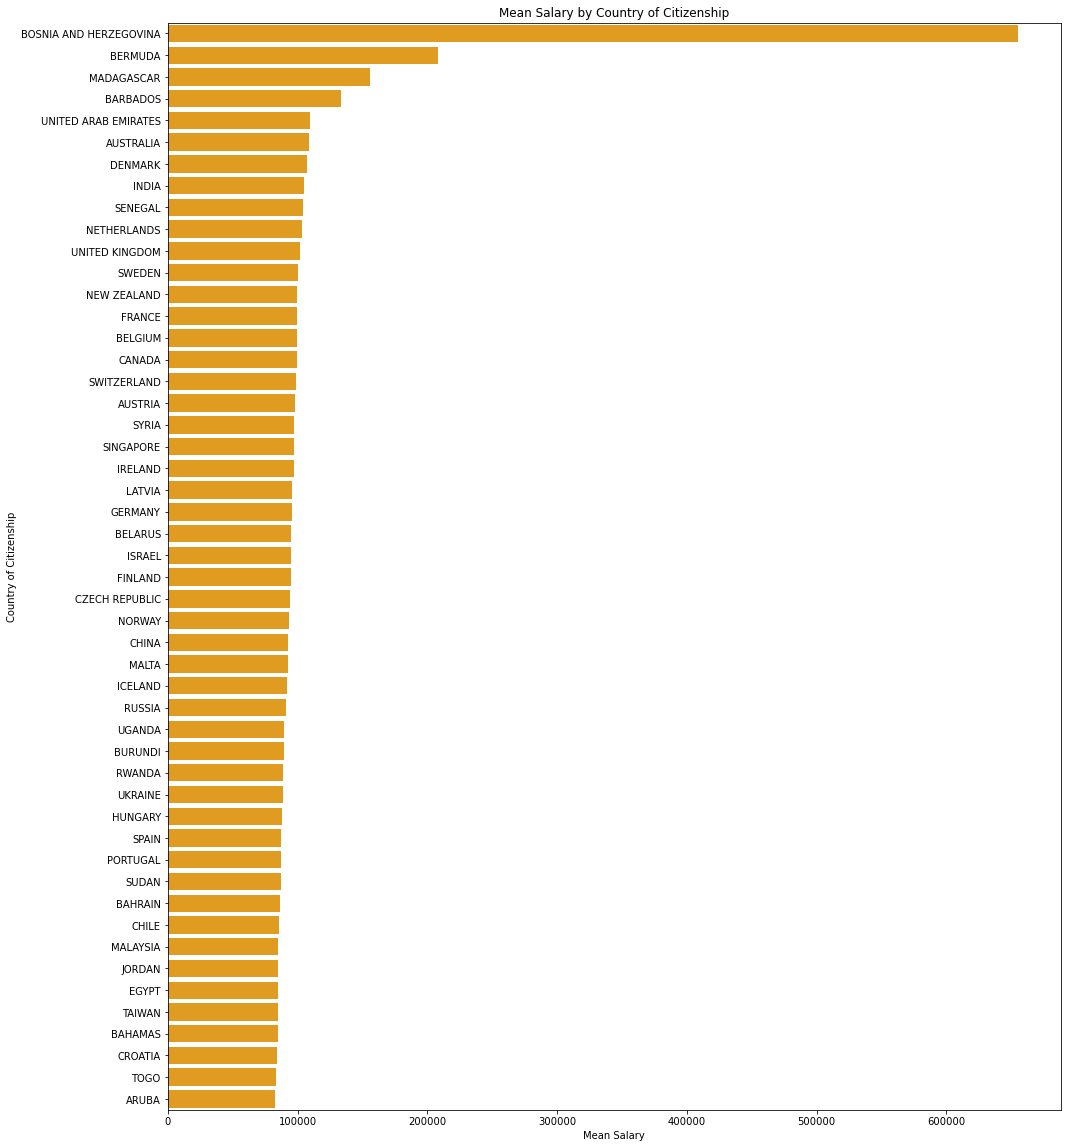

In [66]:
plt.figure(figsize = (16, 20))

table = df.groupby("country_of_citizenship", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(50)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Country of Citizenship', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Country of Citizenship')

Extremely skewed by the one very high salary in this dataset. An unexpected top 5 for this chart. 

Text(0.5, 1.0, 'Mean Salary by Age of Business')

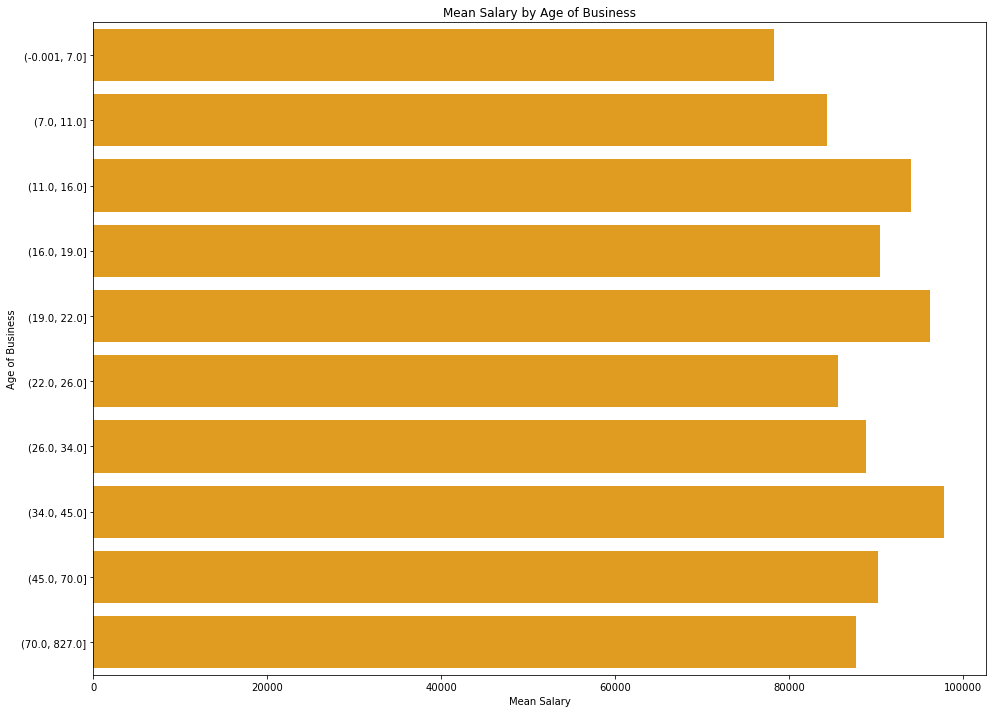

In [130]:
plt.figure(figsize = (16, 12))

table = df.groupby("age_of_business_cut", as_index=False)["pw_wage_adj"].mean().sort_values('pw_wage_adj', ascending=False).head(50)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'orange', orient='h')
ax.set(ylabel = 'Age of Business', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Age of Business')

Little variation by how long the business has been established. 

## Wait Times

Text(0.5, 1.0, 'Mean Wait Time by Decision Month')

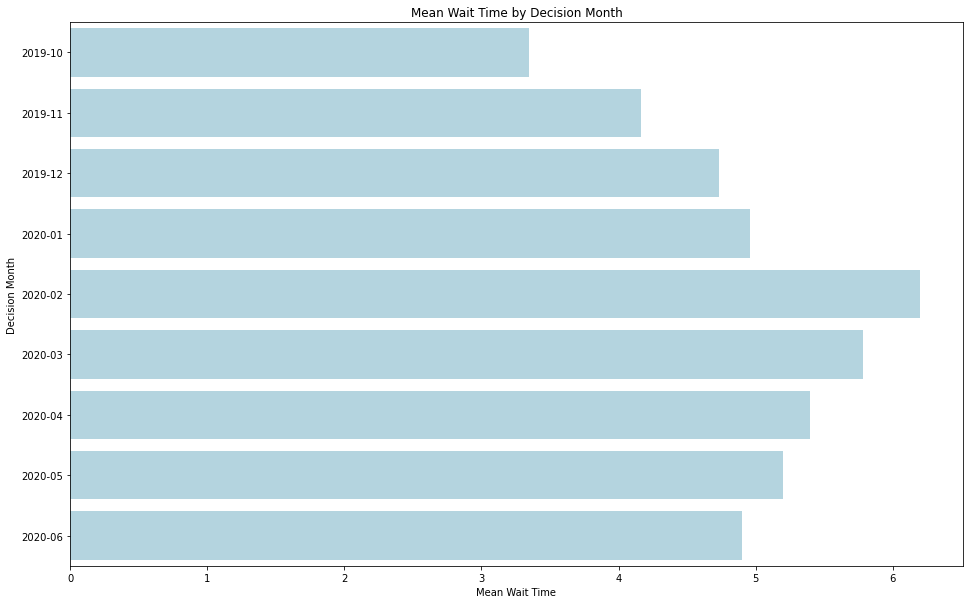

In [134]:
plt.figure(figsize = (16, 10))

table = df.groupby("decision_month", as_index=False)["wait_time"].mean()

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Decision Month', xlabel = 'Mean Wait Time')
ax.set_title('Mean Wait Time by Decision Month')

There actually is a wait time effect, but I have a hunch it's more related to how the data is reported/structured than anything notable. 

Text(0.5, 1.0, 'Mean Wait Time by NAICS Group')

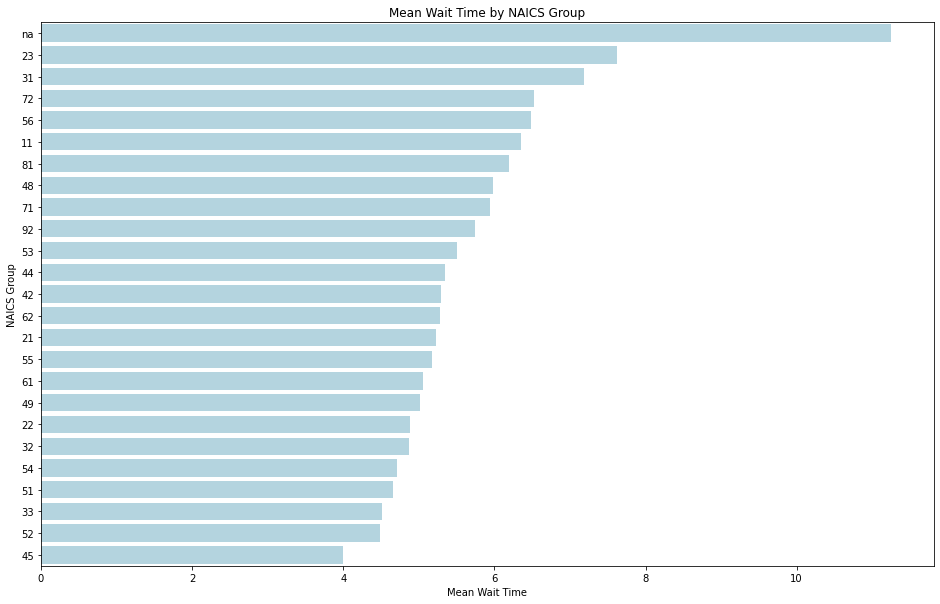

In [67]:
plt.figure(figsize = (16, 10))

table = df.groupby("naics_group", as_index=False)["wait_time"].mean()
table['count'] = table['naics_group'].map(df['naics_group'].value_counts())
table = table.sort_values('wait_time', ascending=False)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h', order = table['naics_group'])
ax.set(ylabel = 'NAICS Group', xlabel = 'Mean Wait Time')
ax.set_title('Mean Wait Time by NAICS Group')

Our highest paid and most accpeted NAICS groups also get the benefit of the shortest wait times. Interesting that the 'na' group has the highest wait times. Indicitive perhaps that applications with missing data or otherwise don't conform are subject to more scrutiny? It could also be that it's an outcome of how applications are processed. 

Text(0.5, 1.0, 'Mean Wait Time by Visa Type')

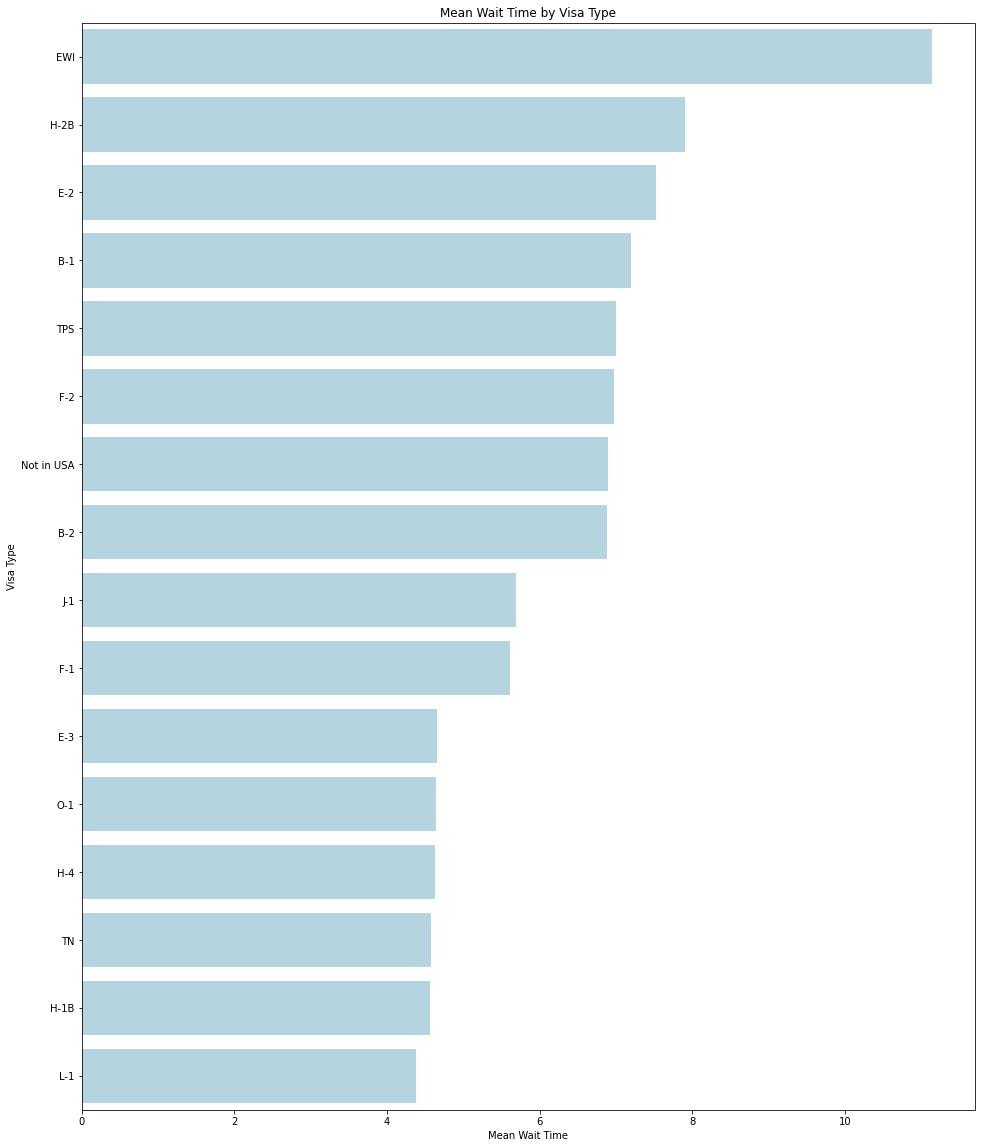

In [179]:
plt.figure(figsize = (16, 20))

table = df.groupby("class_of_admission", as_index=False)["wait_time"].mean().sort_values('wait_time', ascending=False)
table['count'] = table['class_of_admission'].map(df['class_of_admission'].value_counts())
table = table[table['count'] > 150]

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Visa Type', xlabel = 'Mean Wait Time')
ax.set_title('Mean Wait Time by Visa Type')

Generally these are reversed from the acceptance rate charts, suggesting that there's likely pipelines of 'standard' or 'normal' visa processes that fly through the system, and more complicated edge cases that can take much longer. 

Text(0.5, 1.0, 'Mean Salary by Country of Citizenship')

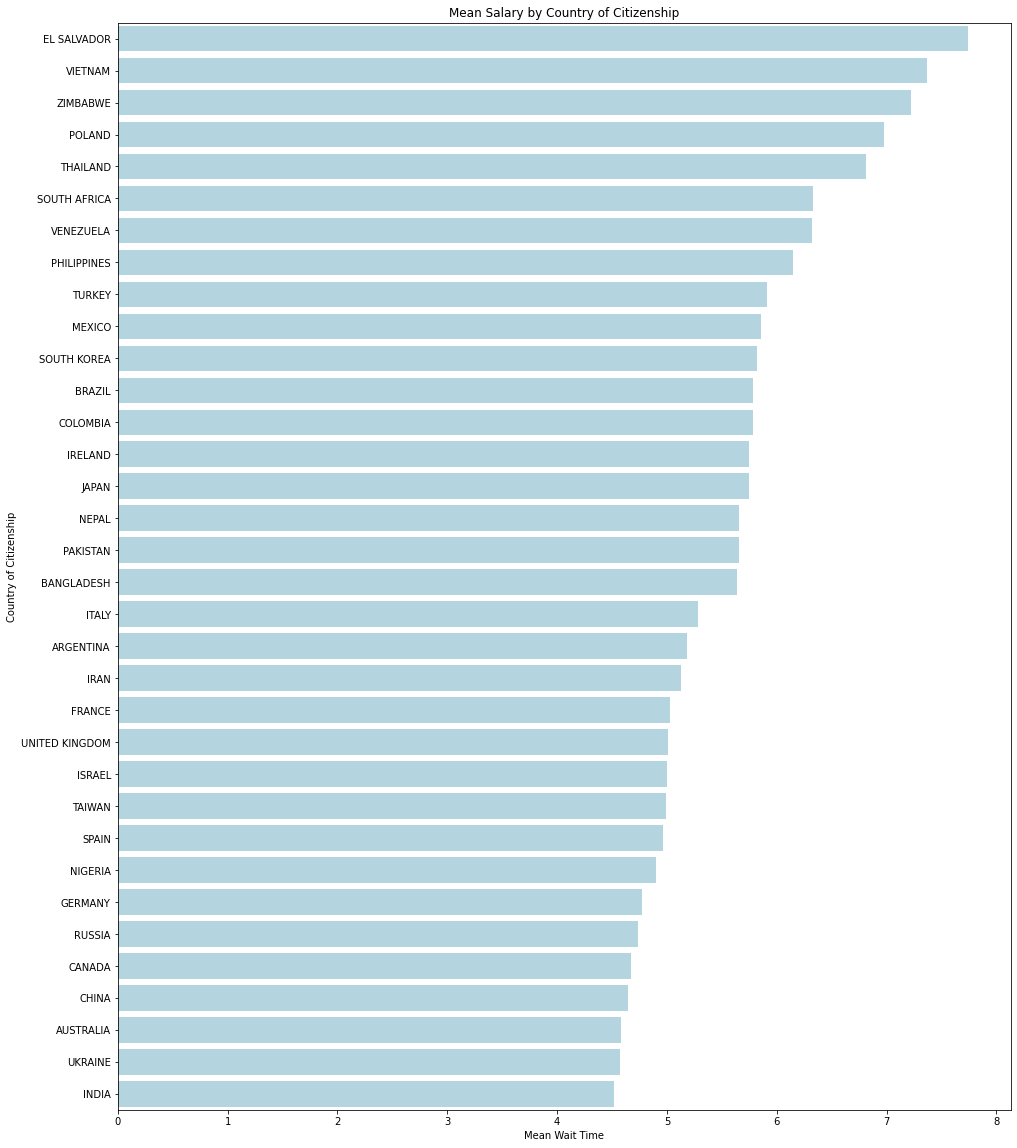

In [68]:
plt.figure(figsize = (16, 20))

table = df.groupby("country_of_citizenship", as_index=False)["wait_time"].mean()
table['count'] = table['country_of_citizenship'].map(df['country_of_citizenship'].value_counts())
table = table[table['count'] > 200].sort_values('wait_time', ascending=False)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Country of Citizenship', xlabel = 'Mean Wait Time')
ax.set_title('Mean Salary by Country of Citizenship')

Same general comment as the visa type chart. 

Text(0.5, 1.0, 'Mean Salary by Age of Business')

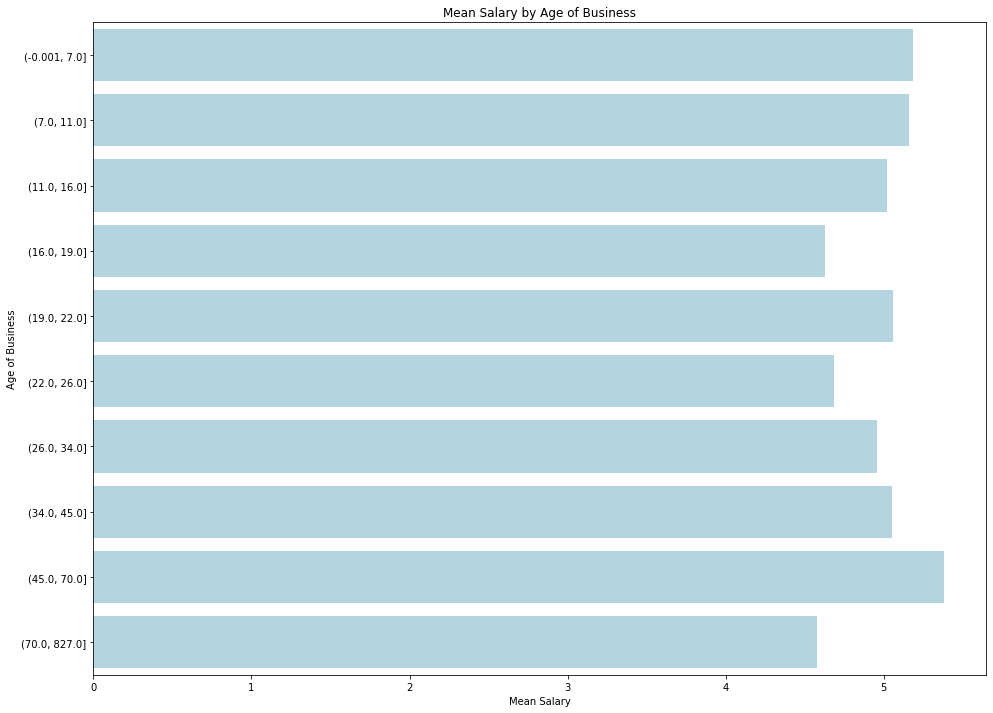

In [184]:
plt.figure(figsize = (16, 12))

table = df.groupby("age_of_business_cut", as_index=False)["wait_time"].mean()
table['count'] = table['age_of_business_cut'].map(df['age_of_business_cut'].value_counts())
table = table.sort_values('wait_time', ascending=False)

ax = sns.barplot(y = table.iloc[:, 0], x = table.iloc[:, 1], color = 'lightblue', orient='h')
ax.set(ylabel = 'Age of Business', xlabel = 'Mean Salary')
ax.set_title('Mean Salary by Age of Business')

No strong effect here. 

## Conclusions

Variety of thoughts here. Clearly there could be value (for business and applicants) to understand their likelihood of success and the length of time that they might expect to wait to see a decision. This could either be in the form of specific predictive models underlying the application (e.g. you could pull in information from the application like country, visa type, NAICS, etc and it could give an estimated probability of success and expected wait time) or simply building out a dashboard to report some of the same descriptive statistics that we've developed in this notebook. 